# Residual Flow

In [6]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from sklearn.datasets import make_moons

from matplotlib import pyplot as plt
from src.models.flows import norm_flow, resid_flow

from tqdm import tqdm

In [23]:
# Set up model

# Define flows
K = 16
torch.manual_seed(0)

latent_size = 2
hidden_units = 128
hidden_layers = 3

flows = []
for i in range(K):
    net = nf.nets.LipschitzMLP([latent_size] + [hidden_units] * (hidden_layers - 1) + [latent_size],
                               init_zeros=True, lipschitz_const=0.9)
    flows += [nf.flows.Residual(net, reduce_memory=True)]
    flows += [nf.flows.ActNorm(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows)
nfm = resid_flow(q0, 2, K=16)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device = torch.device("mps")

nfm = nfm.to(torch.float32).to(device)

# Initialize ActNorm
x_np, _ = make_moons(2 ** 9, noise=0.1)
from src.utils import utils
target = nf.distributions.TwoModes(2, 0.1)
x_np = utils.rejection_sampling_2d(lambda x: torch.exp(target.log_prob(x)), 16384, (-3, 3), (-2, 2))

x = torch.tensor(x_np).float().to(device)
_ = nfm.log_prob(x)

/var/folders/0h/lf8_n8q14p135nrnq0939kkc0000gn/T/ipykernel_50291/3425069512.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_np).float().to(device)


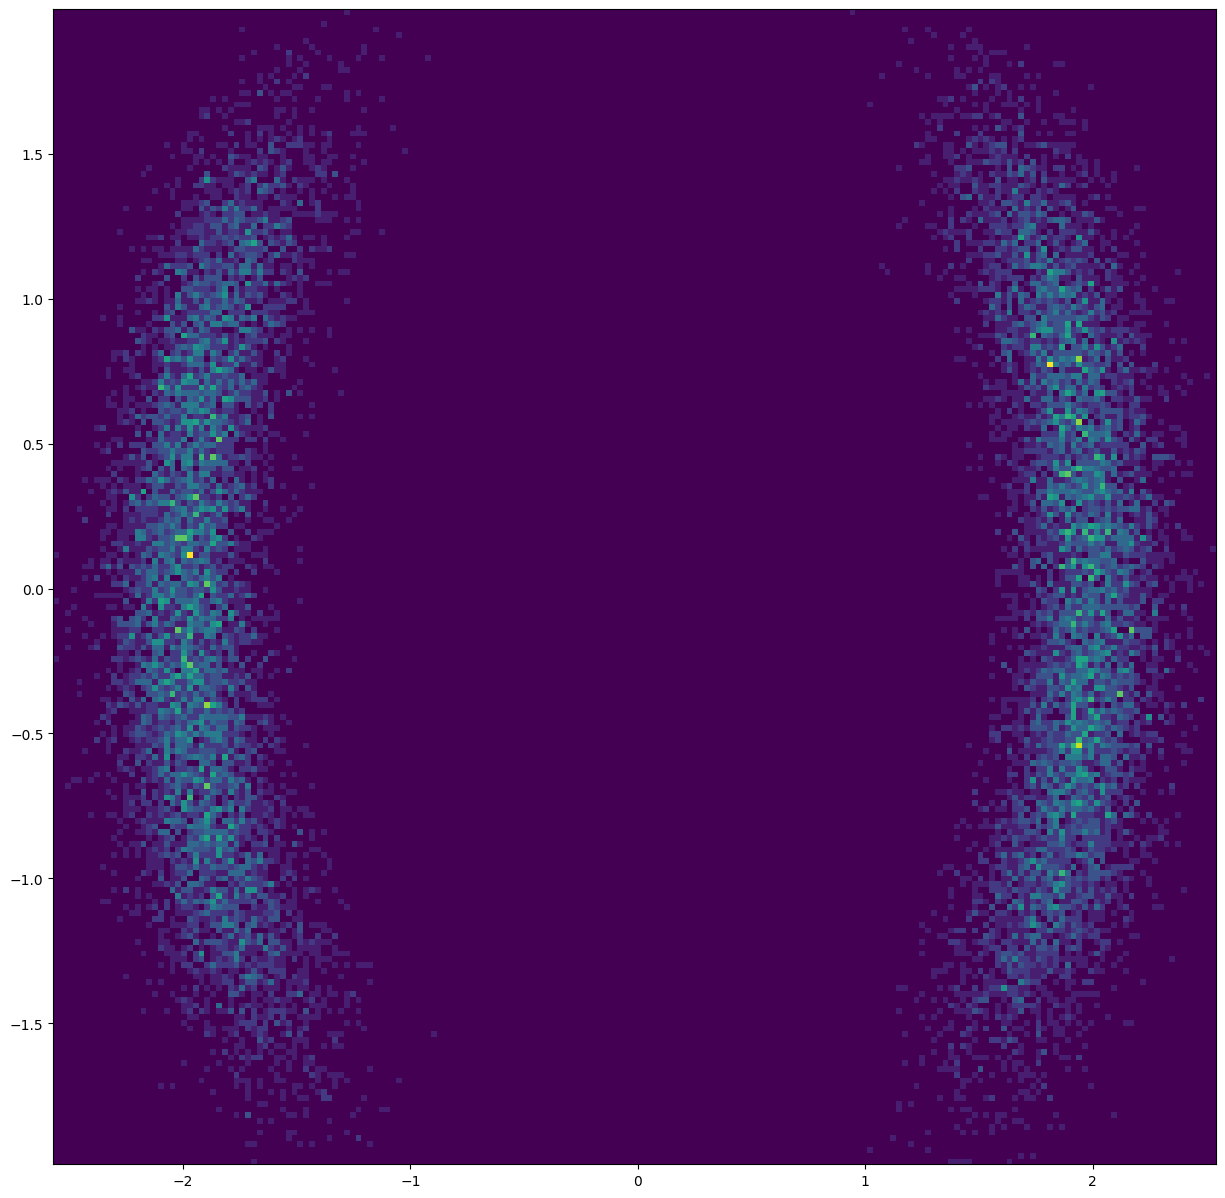

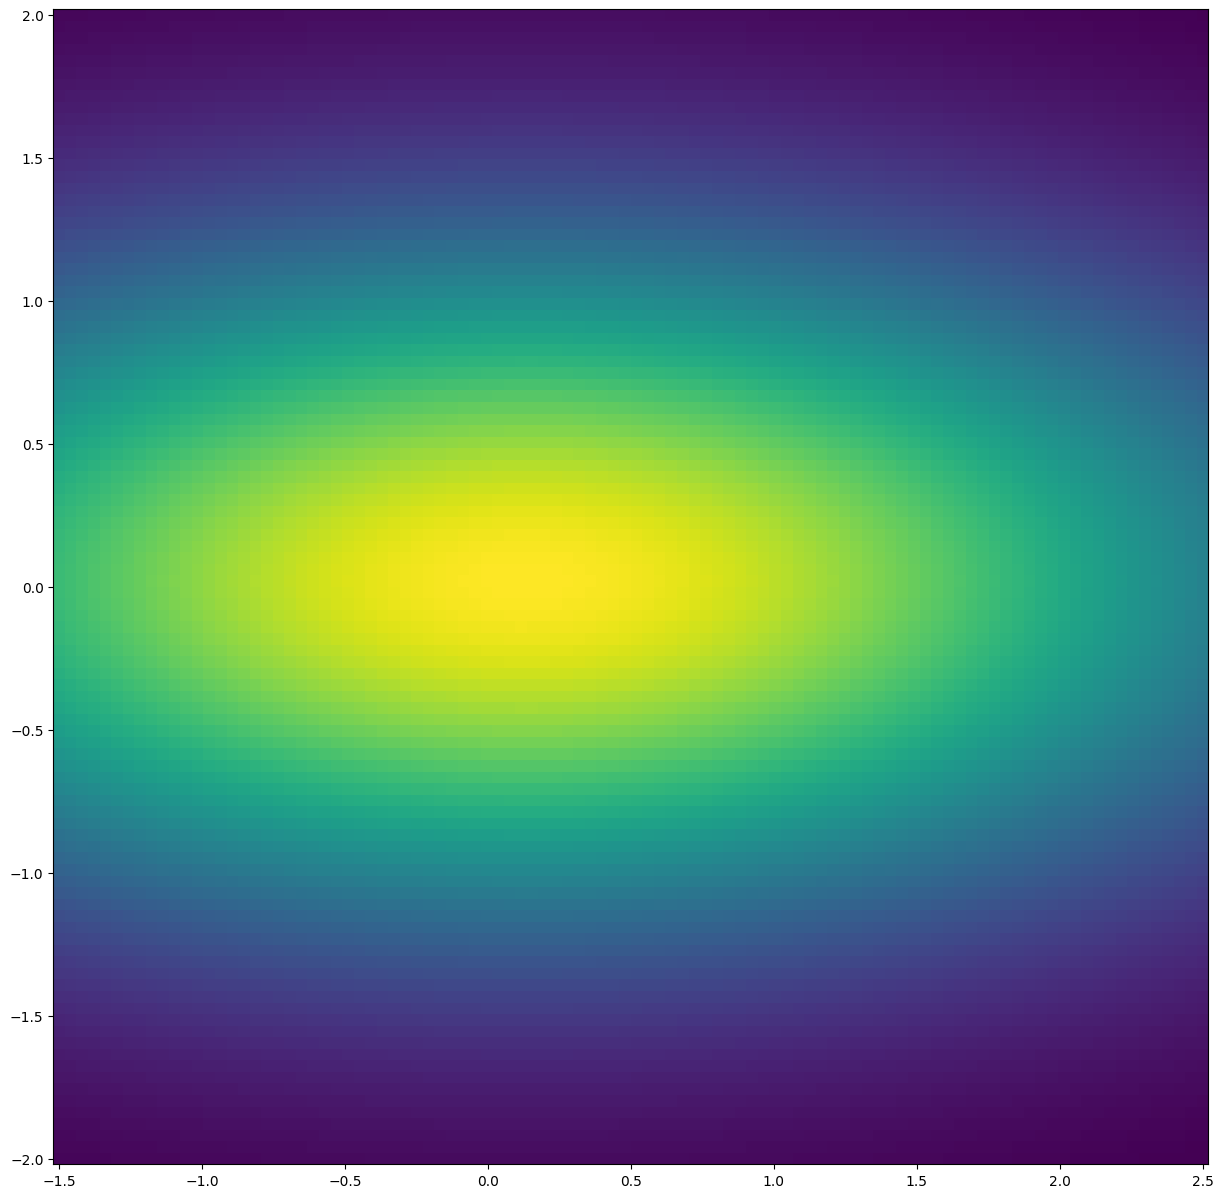

In [24]:
# Plot target distribution
#x_np, _ = make_moons(2 ** 20, noise=0.1)
#x_np = utils.rejection_sampling_2d(lambda x: torch.exp(target.log_prob(x)), 1000, (-3, 3), (-2, 2))

plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

In [ ]:
# Train model
max_iter = 20000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=3e-4, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    #x_np, _ = make_moons(num_samples, noise=0.1)
    #x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
    loss = nfm.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Make layers Lipschitz continuous
    nf.utils.update_lipschitz(nfm, 50)
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        nfm.eval()
        log_prob = nfm.log_prob(zz)
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 88/20000 [03:02<11:43:07,  2.12s/it]

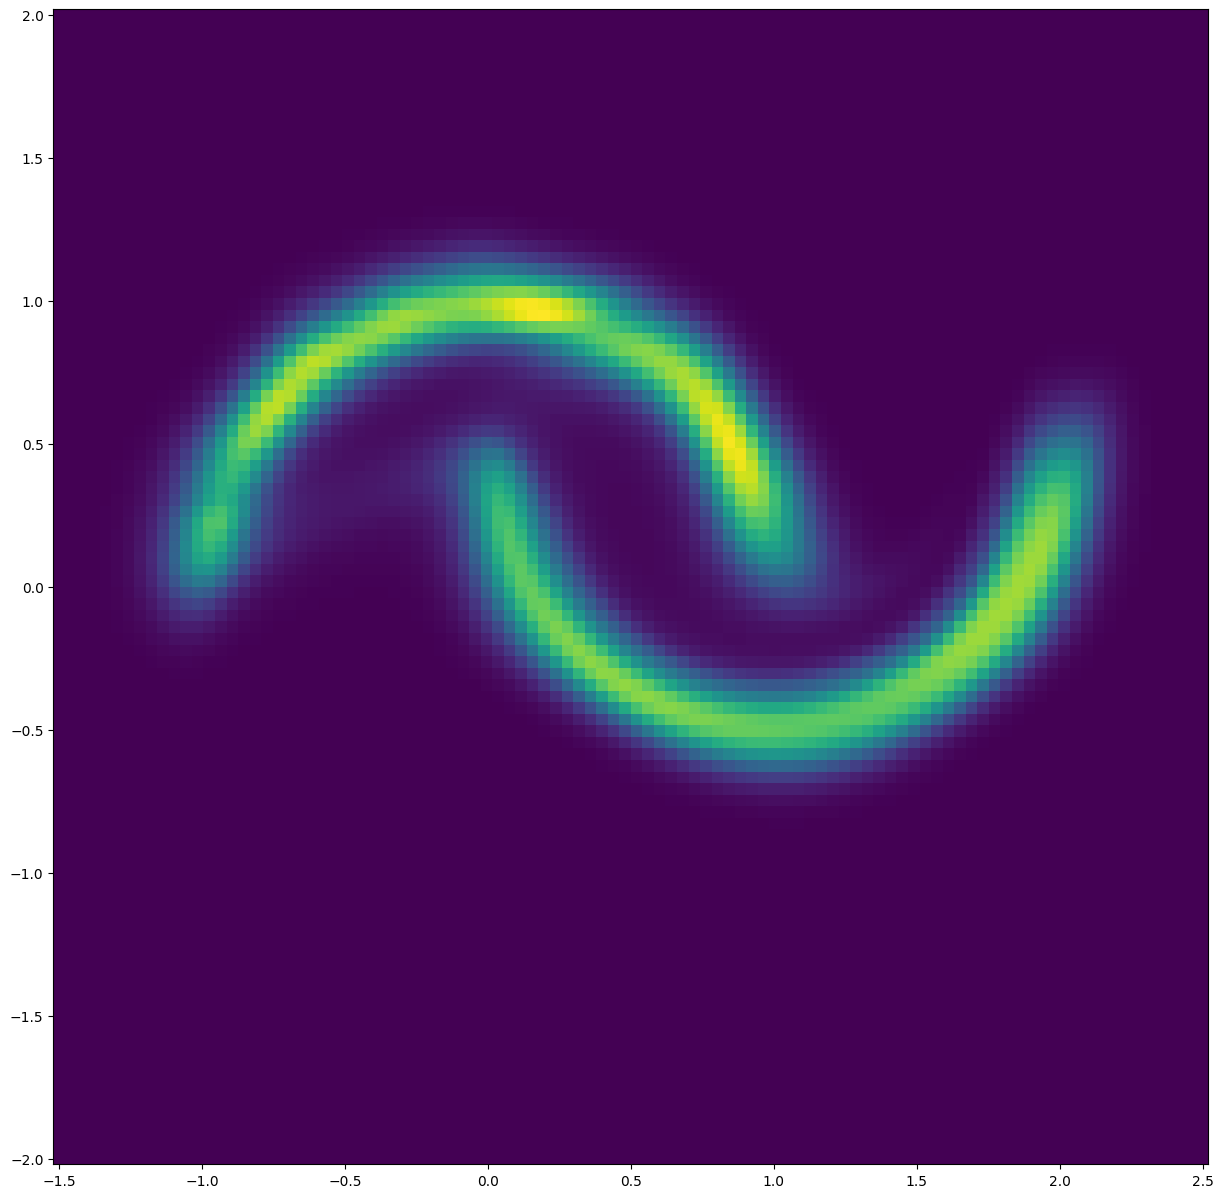

In [5]:
# Plot learned distribution
nfm.eval()
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()